# U-Net method, CAMUS dataset
---
In this notebook, we will train a UNet to segment echocardiographic images from the [CAMUS database](https://www.creatis.insa-lyon.fr/Challenge/camus/index.html) hand-written digit database.

The process will be broken down into the following steps:
>1. Load and visualize the data
2. Define a neural network
3. Train the model
4. Evaluate the performance of our trained model on a test dataset!

Before we begin, we have to import the necessary libraries for working with data and PyTorch.

In [1]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch import Tensor
import torchvision
from torchvision import datasets, transforms
from torchinfo import summary
from torch.utils.data import DataLoader, random_split
import numpy as np
from pathlib import Path
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
import os
from typing import Optional, Union, Tuple
from monai.transforms import LoadImage
from monai.losses import DiceLoss
import matplotlib
import matplotlib.pyplot as plt
# from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"Numpy version: {np.__version__}")

if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

/Users/alexd/anaconda3/envs/monai-dev/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch version: 2.4.1
Torchvision version: 0.19.1
Numpy version: 1.26.4
tensor([1.], device='mps:0')


---
## Load and Visualize the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

Downloading may take a few moments, and you should see your progress as the data is loading.

In [3]:
# Make sure the data is downloaded and extracted where it should be
if not Path("data/camus_32").is_dir():
    import zipfile
    from io import BytesIO
    from urllib.request import urlopen

    zipurl = "https://www.creatis.insa-lyon.fr/~bernard/camus/camus_32.zip"
    with urlopen(zipurl) as zipresp:
        with zipfile.ZipFile(BytesIO(zipresp.read())) as zfile:
            for member in tqdm(
                zfile.infolist(), desc="Downloading and extracting data", position=0, leave=True
            ):
                try:
                    zfile.extract(member, "data/")
                except zipfile.error as e:
                    pass

### Create list of files to create the train, valid, test datasets

Now, let's split these data into training, validation and testing sets. We will use 80% of the data for training, 10% for validation and 10% for testing. The split is done by patient ID, so that the same patient will not appear in different sets.

In [4]:
def subdirs(
    folder: str, join: bool = True, prefix: str = None, suffix: str = None, sort: bool = True
) -> list[str]:
    """Get a list of subdirectories in a folder.

    Args:
        folder: The path to the folder.
        join: Whether to join the folder path with subdirectory names. Defaults to True.
        prefix: Filter subdirectories by prefix. Defaults to None.
        suffix: Filter subdirectories by suffix. Defaults to None.
        sort: Whether to sort the resulting list. Defaults to True.

    Returns:
        A list of subdirectory names in the given folder.
    """
    if join:
        l = os.path.join  # noqa: E741
    else:
        l = lambda x, y: y  # noqa: E731, E741
    res = [
        l(folder, i)
        for i in os.listdir(folder)
        if os.path.isdir(os.path.join(folder, i))
        and (prefix is None or i.startswith(prefix))
        and (suffix is None or i.endswith(suffix))
    ]
    if sort:
        res.sort()
    return res

In [5]:
# Specify the data directory
data_dir = Path("data/camus_32").resolve()

# List all the patients id
keys = subdirs(data_dir, prefix="patient", join=False)

# Split the patients into 80/10/10 train/val/test sets
train_keys, val_and_test_keys = train_test_split(keys, train_size=0.8, random_state=12345)
val_keys, test_keys = train_test_split(val_and_test_keys, test_size=0.5, random_state=12345)

train_keys = sorted(train_keys)
val_keys = sorted(val_keys)
test_keys = sorted(test_keys)

# Create train, val and test datalist
viws_instants = ["2CH_ED", "2CH_ES", "4CH_ED", "4CH_ES"]
train_datalist = [
    {
        "image": str(data_dir / key / f"{key}_{view}.nii.gz"),
        "label": str(data_dir / key / f"{key}_{view}_gt.nii.gz"),
    }
    for key in train_keys
    for view in viws_instants
]

valid_datalist = [
    {
        "image": str(data_dir / key / f"{key}_{view}.nii.gz"),
        "label": str(data_dir / key / f"{key}_{view}_gt.nii.gz"),
    }
    for key in val_keys
    for view in viws_instants
]

test_datalist = [
    {
        "image": str(data_dir / key / f"{key}_{view}.nii.gz"),
        "label": str(data_dir / key / f"{key}_{view}_gt.nii.gz"),
    }
    for key in test_keys
    for view in viws_instants
]

print("Example of train keys: ", train_datalist[:2])
print("Example of validation keys: ", valid_datalist[:2])
print("Example of test keys: ", test_datalist[:2])

Example of train keys:  [{'image': '/Users/alexd/Documents/INSA/5A/Cours/TDSI/TAI/Segmentation/data/camus_32/patient0001/patient0001_2CH_ED.nii.gz', 'label': '/Users/alexd/Documents/INSA/5A/Cours/TDSI/TAI/Segmentation/data/camus_32/patient0001/patient0001_2CH_ED_gt.nii.gz'}, {'image': '/Users/alexd/Documents/INSA/5A/Cours/TDSI/TAI/Segmentation/data/camus_32/patient0001/patient0001_2CH_ES.nii.gz', 'label': '/Users/alexd/Documents/INSA/5A/Cours/TDSI/TAI/Segmentation/data/camus_32/patient0001/patient0001_2CH_ES_gt.nii.gz'}]
Example of validation keys:  [{'image': '/Users/alexd/Documents/INSA/5A/Cours/TDSI/TAI/Segmentation/data/camus_32/patient0012/patient0012_2CH_ED.nii.gz', 'label': '/Users/alexd/Documents/INSA/5A/Cours/TDSI/TAI/Segmentation/data/camus_32/patient0012/patient0012_2CH_ED_gt.nii.gz'}, {'image': '/Users/alexd/Documents/INSA/5A/Cours/TDSI/TAI/Segmentation/data/camus_32/patient0012/patient0012_2CH_ES.nii.gz', 'label': '/Users/alexd/Documents/INSA/5A/Cours/TDSI/TAI/Segmentation

### Create Dataset objects

Once the data is split, we will create a `Dataset` object for each set. This object will be used to load the data during training and testing.

In [6]:
def load_data(image_path, type_image=True):
    
    # Use LoadImage to load a nii.gz file into a tensor
    loader = LoadImage(image_only=True)  # Load image only
    image = loader(image_path)
    image = image.numpy().transpose(1, 0)
    
    # if input image in gray value, put every thing between 0 and 1
    if type_image==True:
        image = image / image.max()
        
    # if input label, make it as a one hot encoding matrix
    else:
        image = image.astype(int)
        image = np.eye(4)[image]
        # Transpose to obtain the desire shape of 4x32x32
        image = image.transpose(2, 0, 1)
    
    return image

In [7]:
class CustomDataset(Dataset):
    def __init__(self, datalist, transform=None):
        self.datalist = datalist
        self.transform = transform

    def __len__(self):
        return len(self.datalist)

    def __getitem__(self, idx):
        # Load image and label from datalist
        image_path = self.datalist[idx]['image']
        label_path = self.datalist[idx]['label']

        # Load files as tensors, as required
        image = load_data(image_path, type_image=True)
        label = load_data(label_path, type_image=False)

        # Apply transformations if necessary
        if self.transform:
            image = self.transform(image)

        return image, label

In [8]:
# How many samples per batch to load
batch_size = 4

# convert data to torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Image normalization between [-1;1]
])

# Choose the training and test datasets
train_dataset = CustomDataset(train_datalist, transform)
valid_dataset = CustomDataset(valid_datalist, transform)
test_dataset = CustomDataset(test_datalist, transform)

# Prepare data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Visualize a Batch of Training Data

The first step in a segmentation task is to take a look at the data, make sure it is loaded in correctly, then make any initial observations about patterns in that data.

In [9]:
def imagesc(
    ax: matplotlib.axes,
    image: Union[Tensor, np.ndarray],
    title: Optional[str] = None,
    colormap: matplotlib.colormaps = plt.cm.gray,
    clim: Optional[tuple[float, float]] = None,
    show_axis: bool = False,
    show_colorbar: bool = True,
    **kwargs,
) -> None:
    """Display image with scaled colors. Similar to Matlab's imagesc.

    Args:
        ax: Axis to plot on.
        image: Array to plot.
        title: Title of plotting.
        colormap: Colormap of plotting.
        clim: Colormap limits.
        show_axis: Whether to show axis when plotting.
        show_colorbar: Whether to show colorbar when plotting.
        **kwargs: Keyword arguments to be passed to `imshow`.

    Example:
        >>> plt.figure("image", (18, 6))
        >>> ax = plt.subplot(1, 2, 1)
        >>> imagesc(ax, np.random.rand(100,100), "image", clim=(-1, 1))
        >>> plt.show()
    """

    if clim is not None and isinstance(clim, (list, tuple)):
        if len(clim) == 2 and (clim[0] < clim[1]):
            clim_args = {"vmin": float(clim[0]), "vmax": float(clim[1])}
        else:
            raise ValueError(
                f"clim should be a list or tuple containing 2 floats with clim[0] < clim[1], "
                f"got {clim} instead.",
            )
    else:
        clim_args = {}

    if isinstance(image, Tensor):
        image = image.cpu().detach().numpy()

    im = ax.imshow(image, colormap, **clim_args, **kwargs)
    plt.title(title)

    if show_colorbar:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="10%", pad=0.05)
        plt.colorbar(im, cax)

    if not show_axis:
        ax.set_axis_off()

train_idx:  361
val_idx:  0
test_idx:  54


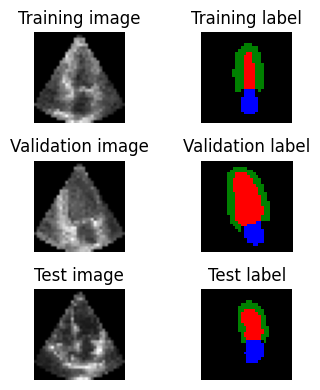

In [10]:
# Get a random index to display the image with label from each dataset
train_idx = np.random.randint(len(train_dataset))
val_idx = np.random.randint(len(valid_dataset))
test_idx = np.random.randint(len(test_dataset))

# Print the selected indices
print("train_idx: ", train_idx)
print("val_idx: ", val_idx)
print("test_idx: ", test_idx)

# Visualize a random image with label from each dataset
colors = ["black", "red", "green", "blue"]
cmap = ListedColormap(colors)

figure = plt.figure(figsize=(4, 4))
image, label = train_dataset[train_idx]
label = np.argmax(label, axis=0)
image = np.squeeze(image)
label = np.squeeze(label)
ax = figure.add_subplot(3, 2, 1)
imagesc(ax, image, title="Training image", show_colorbar=False)
ax = figure.add_subplot(3, 2, 2)
imagesc(
    ax, label, title="Training label", show_colorbar=False, colormap=cmap, interpolation="nearest"
)

image, label = valid_dataset[val_idx]
label = np.argmax(label, axis=0)
image = np.squeeze(image)
label = np.squeeze(label)
ax = figure.add_subplot(3, 2, 3)
imagesc(ax, image, title="Validation image", show_colorbar=False)
ax = figure.add_subplot(3, 2, 4)
imagesc(
    ax,
    label,
    title="Validation label",
    show_colorbar=False,
    colormap=cmap,
    interpolation="nearest",
)

image, label = test_dataset[test_idx]
label = np.argmax(label, axis=0)
image = np.squeeze(image)
label = np.squeeze(label)
ax = figure.add_subplot(3, 2, 5)
imagesc(ax, image, title="Test image", show_colorbar=False)
ax = figure.add_subplot(3, 2, 6)
imagesc(ax, label, title="Test label", show_colorbar=False, colormap=cmap, interpolation="nearest")
figure.tight_layout()
plt.show()


### View an Image / Label in More Detail

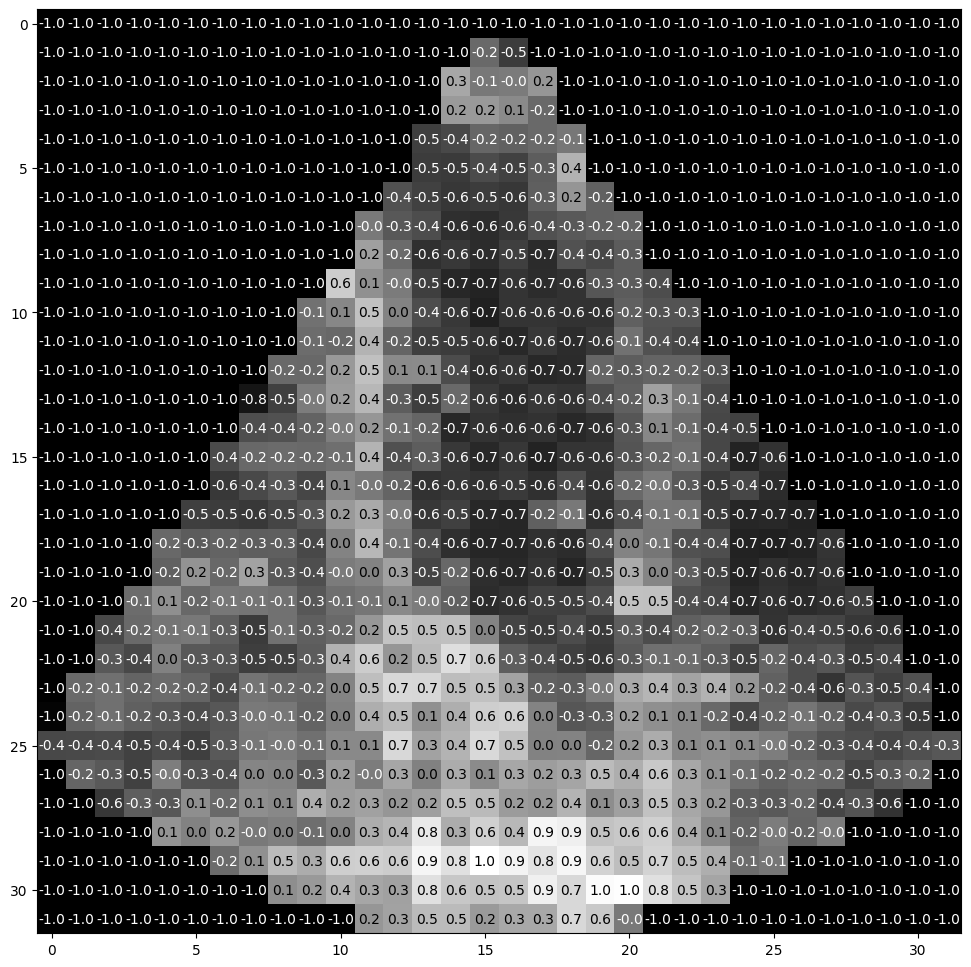

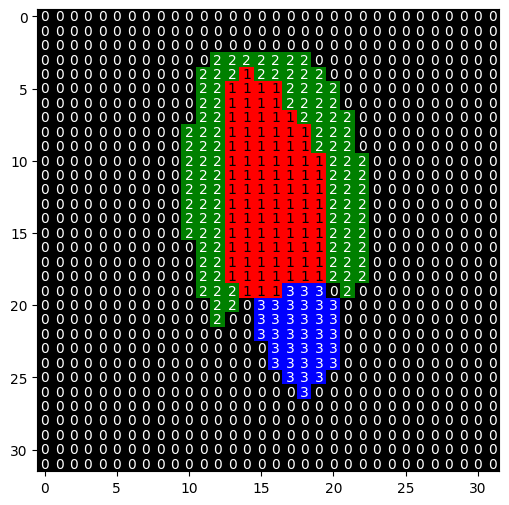

In [11]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()
labels = labels.numpy()

img = np.squeeze(images[0])
fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = 0
for x in range(width):
    for y in range(height):
        val = round(img[x][y],1) if img[x][y] !=0 else 0
        ax.annotate(f"{val:.1f}", xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')
        
label = np.squeeze(labels[0])
label = np.argmax(label, axis=0)
colors = ["black", "red", "green", "blue"]
cmap = ListedColormap(colors)

fig = plt.figure(figsize = (6,6)) 
ax = fig.add_subplot(111)
ax.imshow(label, cmap=cmap)
width, height = label.shape
thresh = 0
for x in range(width):
    for y in range(height):
        val = label[x][y]
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='black' if val==1 else 'white')

<class 'numpy.ndarray'>
(4, 32, 32)


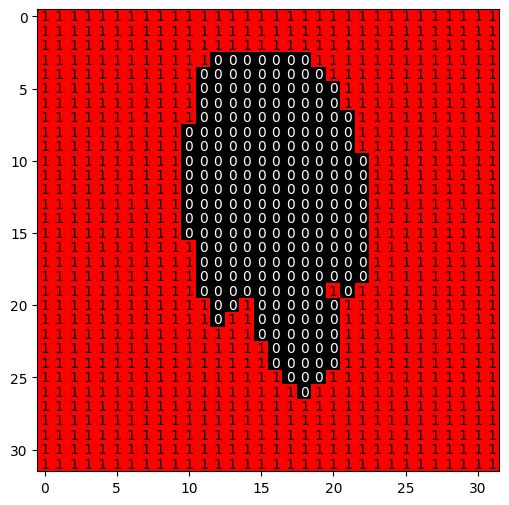

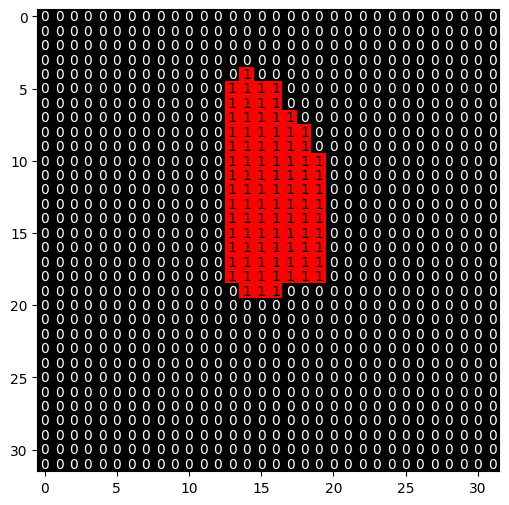

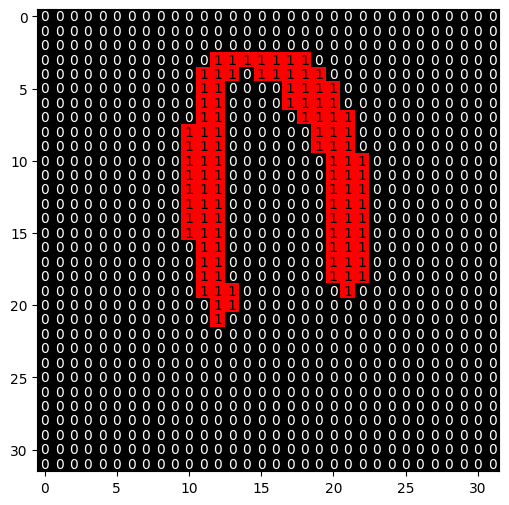

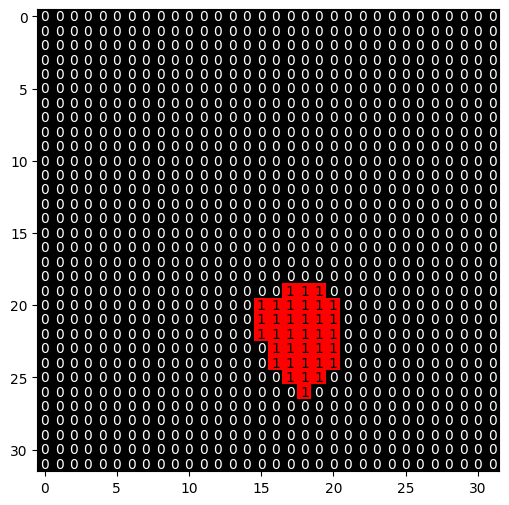

In [12]:
print(type(label))
# img = img.astype(int)
one_hot_label = np.eye(4)[label]
# Transposer pour obtenir la forme désirée 4x32x32
one_hot_label = one_hot_label.transpose(2, 0, 1)
print(one_hot_label.shape)

colors = ["black", "red"]
cmap = ListedColormap(colors)

for idx in range(4):
    fig = plt.figure(figsize = (6,6)) 
    ax = fig.add_subplot(111)
    ax.imshow(one_hot_label[idx,:], cmap=cmap)
    width, height = img.shape
    for x in range(width):
        for y in range(height):
            val = one_hot_label[idx,x,y]
            ax.annotate(f"{val:.0f}", xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='black' if one_hot_label[idx,x,y]==1 else 'white')


---
## Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)

The architecture will be responsible for seeing as input a 784-dim Tensor of pixel values for each image, and producing a Tensor of length 10 (our number of classes) that indicates the class scores for an input image. This particular example uses two hidden layers and dropout to avoid overfitting.

In [13]:
# Model Architecture Parameters
input_shape = (1, 32, 32)  # This is the shape of the input image to the network
num_classes = 4  # This is the number of output classes
output_shape = (num_classes, 32, 32)  # This is the shape of the output mask
init_channels = 32  # This is the number of channels in the first layer of the network


In [14]:
class UNet(nn.Module):
    """Architecture based on U-Net: Convolutional Networks for Biomedical Image Segmentation.

    References:
    - Paper that introduced the U-Net model: https://arxiv.org/abs/1505.04597
    """

    def __init__(
        self,
        input_shape: Tuple[int, ...],
        output_shape: Tuple[int, ...],
        init_channels: int = 32,
        use_batchnorm: bool = True,
        bilinear: bool = False,
        dropout: float = 0.0,
    ):
        """Initializes class instance.

        Args:
            input_shape: (in_channels, H, W), Shape of the input images.
            output_shape: (num_classes, H, W), Shape of the output segmentation map.
            init_channels: Number of output feature maps from the first layer, used to compute the number of feature
                maps in following layers.
            use_batchnorm: Whether to use batch normalization between the convolution and activation layers in the
                convolutional blocks.
            bilinear: Whether to use bilinear interpolation or transposed convolutions for upsampling.
            dropout: Probability of an element to be zeroed (e.g. 0 means no dropout).
        """
        super().__init__()
        in_channels = input_shape[0]
        out_channels = output_shape[0]

        self.layer1 = _DoubleConv(in_channels, init_channels // 2, dropout / 2, use_batchnorm)
        self.layer2 = _Down(init_channels // 2, init_channels, dropout, use_batchnorm)
        self.layer3 = _Down(init_channels, init_channels * 2, dropout, use_batchnorm)
        self.layer4 = _Down(init_channels * 2, init_channels * 4, dropout, use_batchnorm)

        self.layer5 = _Up(
            init_channels * 4, init_channels * 2, dropout, use_batchnorm, bilinear=bilinear
        )
        self.layer6 = _Up(
            init_channels * 2, init_channels, dropout, use_batchnorm, bilinear=bilinear
        )
        self.layer7 = _Up(init_channels, init_channels // 2, 0, use_batchnorm, bilinear=bilinear)

        self.layer9 = nn.Conv2d(init_channels // 2, out_channels, kernel_size=1)

        # Use Xavier initialisation for weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.xavier_uniform_(m.weight)

    def forward(self, x: Tensor) -> Tensor:
        """Defines the computation performed at every call.

        Args:
            x: (N, ``in_channels``, H, W), Input image to segment.

        Returns:
            (N, ``out_channels``, H, W), Raw, unnormalized scores for each class in the input's segmentation.
        """
        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)

        out = self.layer5(x4, x3)
        out = self.layer6(out, x2)
        out = self.layer7(out, x1)

        return self.layer9(out)


class _DoubleConv(nn.Module):
    """Double Convolution and BN and ReLU.

    (3x3 conv -> BN -> ReLU) ** 2
    """

    def __init__(self, in_ch: int, out_ch: int, dropout_prob: float, use_batchnorm: bool):
        super().__init__()
        if use_batchnorm:
            self.net = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.Dropout(p=dropout_prob),
                nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.Dropout(p=dropout_prob),
            )
        else:
            self.net = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Dropout(p=dropout_prob),
                nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Dropout(p=dropout_prob),
            )

    def forward(self, x: Tensor) -> Tensor:
        return self.net(x)


class _Down(nn.Module):
    """Combination of MaxPool2d and DoubleConv in series."""

    def __init__(self, in_ch: int, out_ch: int, dropout_prob: float, use_batchnorm: bool):
        super().__init__()
        self.net = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            _DoubleConv(in_ch, out_ch, dropout_prob, use_batchnorm),
        )

    def forward(self, x: Tensor) -> Tensor:  # noqa: D102
        return self.net(x)


class _Up(nn.Module):
    """Upsampling (by either bilinear interpolation or transpose convolutions).

    followed by concatenation of feature map from contracting path, followed by double 3x3
    convolution.
    """

    def __init__(
        self, in_ch, out_ch: int, dropout_prob: float, use_batchnorm: bool, bilinear: bool = False
    ):
        super().__init__()
        self.upsample = None
        if bilinear:
            self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        else:
            self.upsample = nn.ConvTranspose2d(in_ch, in_ch // 2, kernel_size=2, stride=2)

        self.conv = _DoubleConv(in_ch, out_ch, dropout_prob, use_batchnorm)

    def forward(self, x: Tensor, connected_encoder_features: Tensor) -> Tensor:
        x = self.upsample(x)

        # Pad ``x`` to the size of ``connected_encoder_features``
        diff_h = connected_encoder_features.shape[2] - x.shape[2]
        diff_w = connected_encoder_features.shape[3] - x.shape[3]

        x = F.pad(x, [diff_w // 2, diff_w - diff_w // 2, diff_h // 2, diff_h - diff_h // 2])

        # Concatenate along the channels axis
        x = torch.cat([connected_encoder_features, x], dim=1)

        return self.conv(x)


# initialize the NN
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(input_shape=input_shape, output_shape=output_shape, init_channels=init_channels).to(mps_device)

# Print the summary of the network
summary_kwargs = dict(
    col_names=["input_size", "output_size", "kernel_size", "num_params"], depth=3, verbose=0
)
summary(model, (1, *input_shape), device="mps", **summary_kwargs)

Layer (type:depth-idx)                        Input Shape               Output Shape              Kernel Shape              Param #
UNet                                          [1, 1, 32, 32]            [1, 4, 32, 32]            --                        --
├─_DoubleConv: 1-1                            [1, 1, 32, 32]            [1, 16, 32, 32]           --                        --
│    └─Sequential: 2-1                        [1, 1, 32, 32]            [1, 16, 32, 32]           --                        --
│    │    └─Conv2d: 3-1                       [1, 1, 32, 32]            [1, 16, 32, 32]           [3, 3]                    160
│    │    └─BatchNorm2d: 3-2                  [1, 16, 32, 32]           [1, 16, 32, 32]           --                        32
│    │    └─ReLU: 3-3                         [1, 16, 32, 32]           [1, 16, 32, 32]           --                        --
│    │    └─Dropout: 3-4                      [1, 16, 32, 32]           [1, 16, 32, 32]           --     

###  Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

It's recommended that you use cross-entropy loss for classification. If you look at the documentation (linked above), you can see that PyTorch's cross entropy function applies a softmax funtion to the output layer *and* then calculates the log loss.

In [15]:
## Specify loss and optimization functions

# Parameters
learning_rate = 0.001
n_epochs = 20

# specify loss function
# criterion = DiceLoss()
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

---
## Train the Network

The steps for training/learning from a batch of data are described in the comments below:
1. Clear the gradients of all optimized variables
2. Forward pass: compute predicted outputs by passing inputs to the model
3. Calculate the loss
4. Backward pass: compute gradient of the loss with respect to model parameters
5. Perform a single optimization step (parameter update)
6. Update average training loss

The following loop trains for 30 epochs; feel free to change this number. For now, we suggest somewhere between 20-50 epochs. As you train, take a look at how the values for the training loss decrease over time. We want it to decrease while also avoiding overfitting the training data. 

In [16]:
# Move the model to the device
model = model.to(mps_device)

# Lists to store loss and accuracy for each epoch
train_losses = []
valid_losses = []

best_metric = -1  # to track the best validation loss
best_valid_loss = float('inf')
best_model = None  # to store the best model
best_epoch = 0  # to track the epoch number of the best model

model.train()  # prepare model for training

for epoch in range(n_epochs):
    
    epoch_tp_hard = []
    epoch_fp_hard = []
    epoch_fn_hard = []    
    
    # monitor training loss
    train_loss = 0.0
    model.train()  # ensure the model is in training mode
    
    ###################
    # train the model #
    ###################
        
    for batch_data in train_loader:
        # Load data and target samples stored the current batch_data
        #images, labels = batch_data[0].to(mps_device), batch_data[1].to(mps_device)
        images, labels = batch_data[0].to(torch.float32).to(mps_device), batch_data[1].to(torch.float32).to(mps_device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(images)
        # calculate the loss
        loss = criterion(output, labels)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
              
        
    # Calculate average training loss and accuracy over the epoch
    train_loss = train_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    ###################
    # Validation step #
    ###################    
    model.eval()  # set model to evaluation mode
    valid_loss = 0.0

    with torch.no_grad():  # disable gradient calculation during validation
        for batch_data in valid_loader:
            # Load data and target samples stored the current batch_data
            val_inputs, val_labels = batch_data[0].to(torch.float32).to(mps_device), batch_data[1].to(torch.float32).to(mps_device)
            # forward pass: compute predicted outputs by passing inputs to the model
            val_outputs = model(val_inputs)
            # calculate the loss
            val_loss = criterion(val_outputs, val_labels)
            # update running validation loss
            valid_loss += val_loss.item() * val_inputs.size(0)

        # Compute average validation loss and accuracy
        valid_loss = valid_loss / len(valid_loader.dataset)
        valid_losses.append(valid_loss)
        
        print(f'Epoch: {epoch+1} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}')

        # Save the model if it has the best validation loss
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_model = model.state_dict()
            best_epoch = epoch + 1  # Save the epoch number

# After training, load the best model
model.load_state_dict(best_model)
torch.save(best_model, 'best_model.pth')  # Save the best model
print(f"Best model selected at epoch {best_epoch} with validation loss: {best_valid_loss:.4f}")


Epoch: 1 	Training Loss: 0.2920 	Validation Loss: 0.1494
Epoch: 2 	Training Loss: 0.1351 	Validation Loss: 0.1183
Epoch: 3 	Training Loss: 0.1165 	Validation Loss: 0.1148


KeyboardInterrupt: 

---
## Display train / valid curves

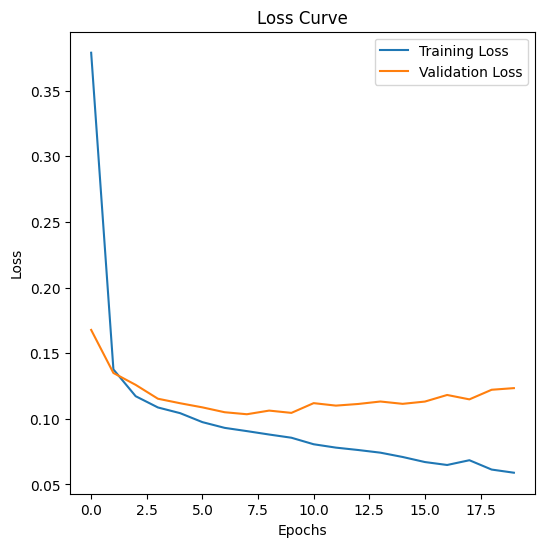

In [16]:
# Plot loss curves
plt.figure(figsize=(6, 6))

# Plotting Training and Validation Loss
plt.subplot(1, 1, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


### Perform the inference on the test set
First, we create the dataloader from the test dataset we defined at the beginning.

In [17]:
# Create the test dataloader
num_workers = os.cpu_count() - 1

test_dataloader = DataLoader(
    test_dataset, 
    batch_size=1, 
    pin_memory=torch.cuda.is_available(), 
    shuffle=False
)

# Create an iterator to iterate over the test dataloader
test_dataloader_iter = iter(test_dataloader)

Then, we perform the inference on a sample from the test dataset and plot the prediction.

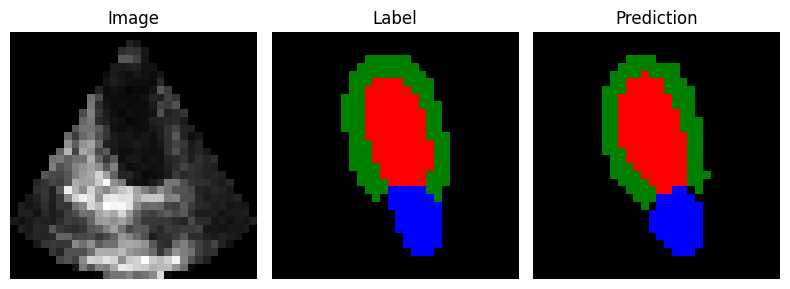

In [34]:
model.to(device)
# Put the U-Net in evaluation mode
model.eval()

batch_data = next(test_dataloader_iter)
# batch_data = next(test_dataloader_iter)
with torch.no_grad():
    
    image, label = batch_data[0].to(device), batch_data[1].to(device)
    pred = model(image)
    pred = F.softmax(pred, dim=1).argmax(dim=1)
    pred = pred.squeeze().detach().cpu().numpy()
    image = image.squeeze().detach().cpu().numpy()
    label = label.squeeze().detach().cpu().numpy()
    label = np.argmax(label, axis=0)

colors = ["black", "red", "green", "blue"]
cmap = ListedColormap(colors)

# Plot the image, label and prediction
figure = plt.figure(figsize=(8, 8))
ax = figure.add_subplot(1, 3, 1)
imagesc(ax, image, title="Image", show_colorbar=False)
ax = figure.add_subplot(1, 3, 2)
imagesc(ax, label, title="Label", show_colorbar=False, colormap=cmap, interpolation="nearest")
ax = figure.add_subplot(1, 3, 3)
imagesc(ax, pred, title="Prediction", show_colorbar=False, colormap=cmap, interpolation="nearest")
figure.tight_layout()
plt.show()